# Modelo de OneClassSVM entrenado con 4F de datos Astro, y predicción sobre datos Unid (no identificados)

**Proyecto**: Detección de posibles fuentes de materia oscura usando ML en datos Fermi-LAT  
**Autor**: Marta Canino Romero  
**Fecha**: febrero-mayo 20225

---

## Descripción:

Este notebook aplica un modelo **One-Class SVM** entrenado con datos de fuentes astrofísicas conocidas (ASTRO) usando las siguientes características:

- E_peak
- beta
- sigma
- betaRel

Este modelo se entrena para identificar anomalías que puedan corresponder a posibles fuentes de materia oscura (UNIDs) en los datos no identificados del catálogo 4FGL.

---

## Objetivos específicos:

- Entrenar modelo OCSVM con 4 features
- Optimizar hiperparámetros (grid search sobre `nu` y `gamma`)
- Evaluar sobre datos de validación y prueba
- Aplicar modelo final sobre datos UNID para predicción
- Comparar los resultados de anomalía/outliers para OCSVM 4F con los resultados de probabilidad de DM de la ANN 4F (sobre UNIDs)

---

## Entrada de datos:

- '../data/astro_df.txt`

In [722]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle

from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.utils.multiclass import unique_labels

from mpl_toolkits.mplot3d import Axes3D

from itertools import combinations

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

# Configurar estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)

In [723]:
# data_path = "../data/astro_df.txt"
data_path = "../data/astro_data_with_labels.txt"

df_astro = pd.read_csv(data_path, sep='\s+')
print(f" Nombres de las columnas: {list(df_astro.columns)}")

# Renombramos la columna target por claridad
df_astro = df_astro.rename(columns={"astro_DM": "class"})

print(f"Dataset cargado. Forma: {df_astro.shape}")
print(f"Nombres de las columnas: {list(df_astro.columns)}")

display(df_astro.head())


 Nombres de las columnas: ['Log(E_peak)', 'Log(beta)', 'Log(sigma)', 'Log(beta_Rel)', 'astro_DM']
Dataset cargado. Forma: (2831, 5)
Nombres de las columnas: ['Log(E_peak)', 'Log(beta)', 'Log(sigma)', 'Log(beta_Rel)', 'class']


,Log(E_peak),Log(beta),Log(sigma),Log(beta_Rel),class
0,-0.412502,-1.325139,1.356951,-0.122193,0.0
1,0.708140,-0.000174,0.623167,-1.601886,0.0
2,0.224740,-0.581202,1.010041,-0.311249,0.0
3,0.257319,-0.561933,0.615413,-0.038913,0.0
4,0.326110,-1.100179,1.624932,-0.528753,0.0


In [724]:

# Selección de características
features = ['Log(E_peak)', 'Log(beta)', 'Log(sigma)', 'Log(beta_Rel)']
"""Establecemos la columna objetivo aunque al ser un problema de detección de anomalías no la utilizaremos para entrenar el modelo.
Además de que todos los datos están etiquetados como 'astro_DM' = 0.0"""
target = 'class'

print(f"Modelo 4D con features: {features}")
print(f"Dimensionalidad del espacio: {len(features)}D")

# Comprobamos valores nulos
print("\n Valores faltantes por columna:")
print(df_astro[features + [target]].isnull().sum())

print("\n Muestra del dataset:")
display(df_astro[features + [target]].head())

Modelo 4D con features: ['Log(E_peak)', 'Log(beta)', 'Log(sigma)', 'Log(beta_Rel)']
Dimensionalidad del espacio: 4D

 Valores faltantes por columna:
Log(E_peak)      0
Log(beta)        0
Log(sigma)       0
Log(beta_Rel)    0
class            0
dtype: int64

 Muestra del dataset:


,Log(E_peak),Log(beta),Log(sigma),Log(beta_Rel),class
0,-0.412502,-1.325139,1.356951,-0.122193,0.0
1,0.708140,-0.000174,0.623167,-1.601886,0.0
2,0.224740,-0.581202,1.010041,-0.311249,0.0
3,0.257319,-0.561933,0.615413,-0.038913,0.0
4,0.326110,-1.100179,1.624932,-0.528753,0.0


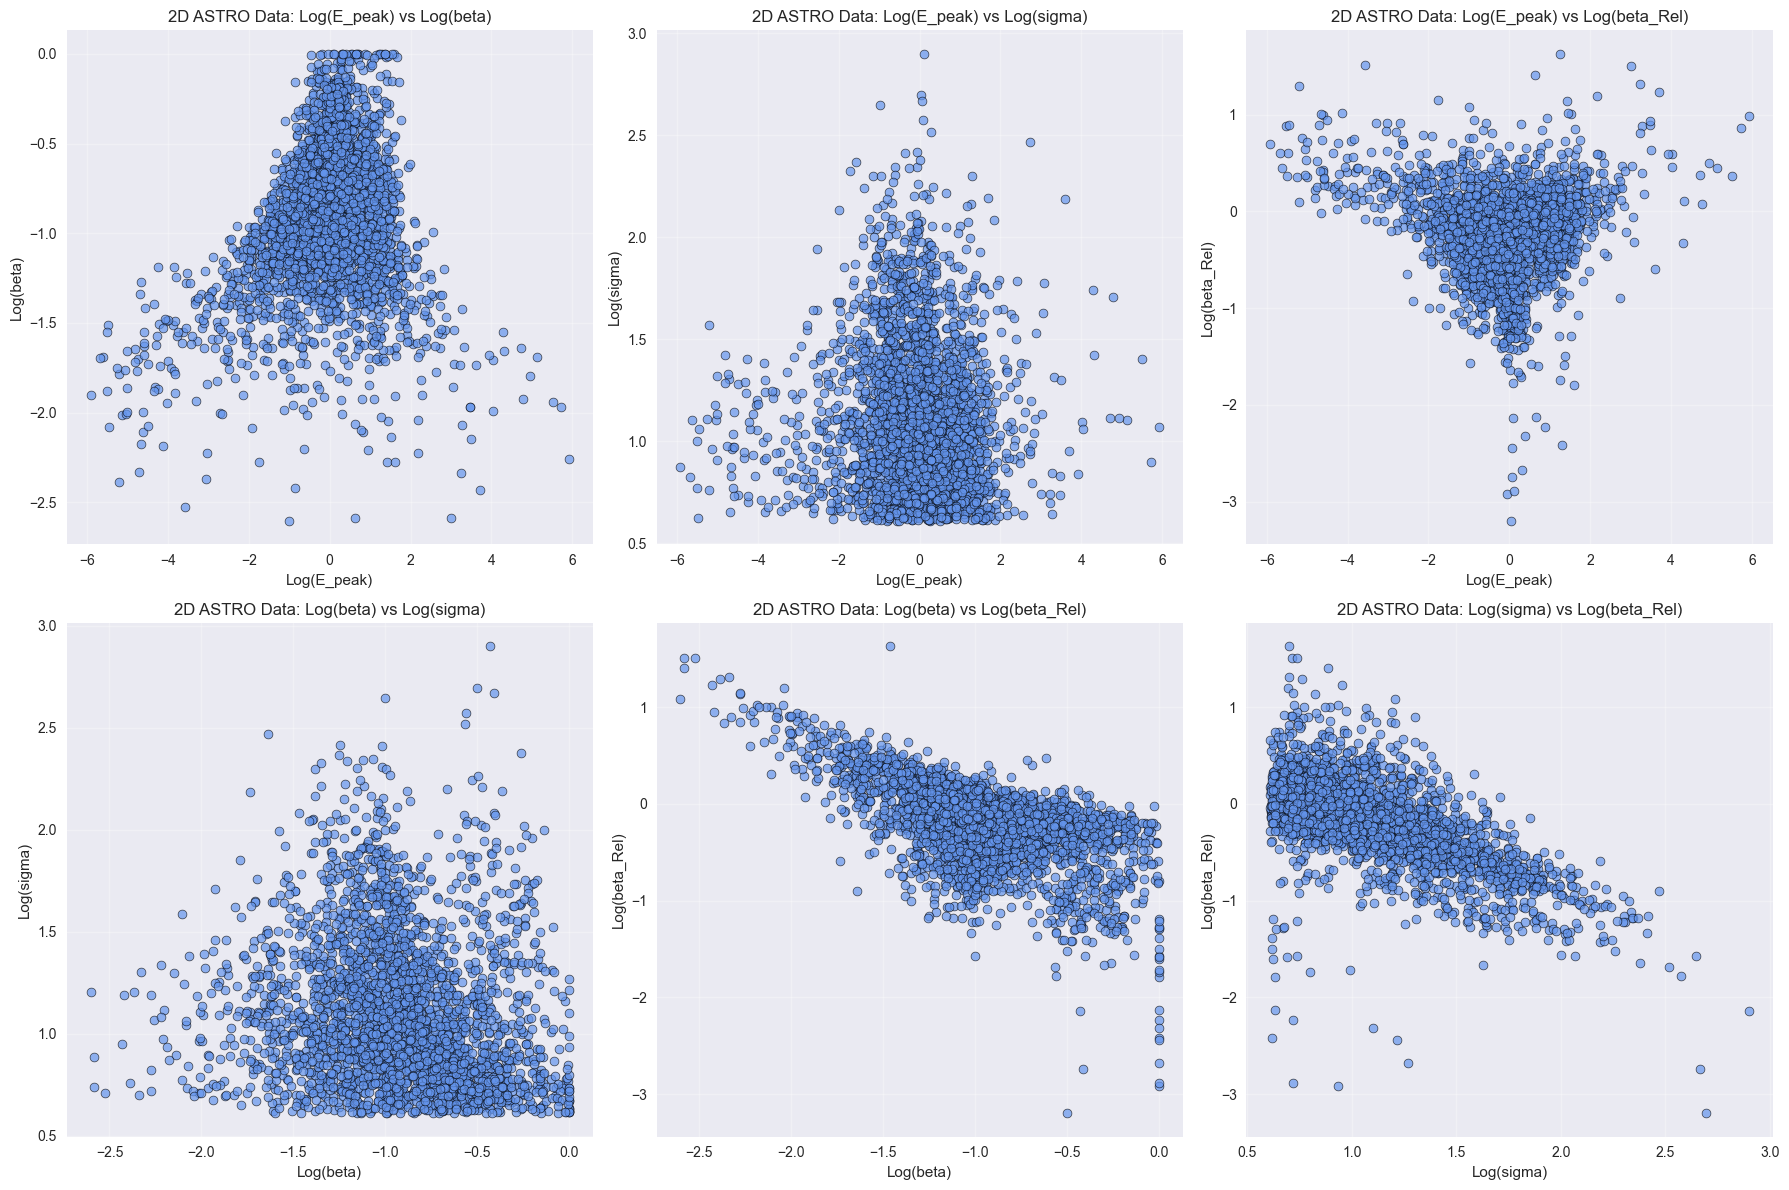

In [725]:
# Crear figura con todas las combinaciones 2D
features = ['Log(E_peak)', 'Log(beta)', 'Log(sigma)', 'Log(beta_Rel)']
feature_pairs = list(combinations(features, 2))

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (feat1, feat2) in enumerate(feature_pairs):
    ax = axes[idx]
    
    sns.scatterplot(
        data=df_astro,
        x=feat1,
        y=feat2,
        color="cornflowerblue",
        edgecolor='k',
        alpha=0.7,
        s=40,
        ax=ax
    )
    
    ax.set_title(f"2D ASTRO Data: {feat1} vs {feat2}")
    ax.set_xlabel(feat1)
    ax.set_ylabel(feat2)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

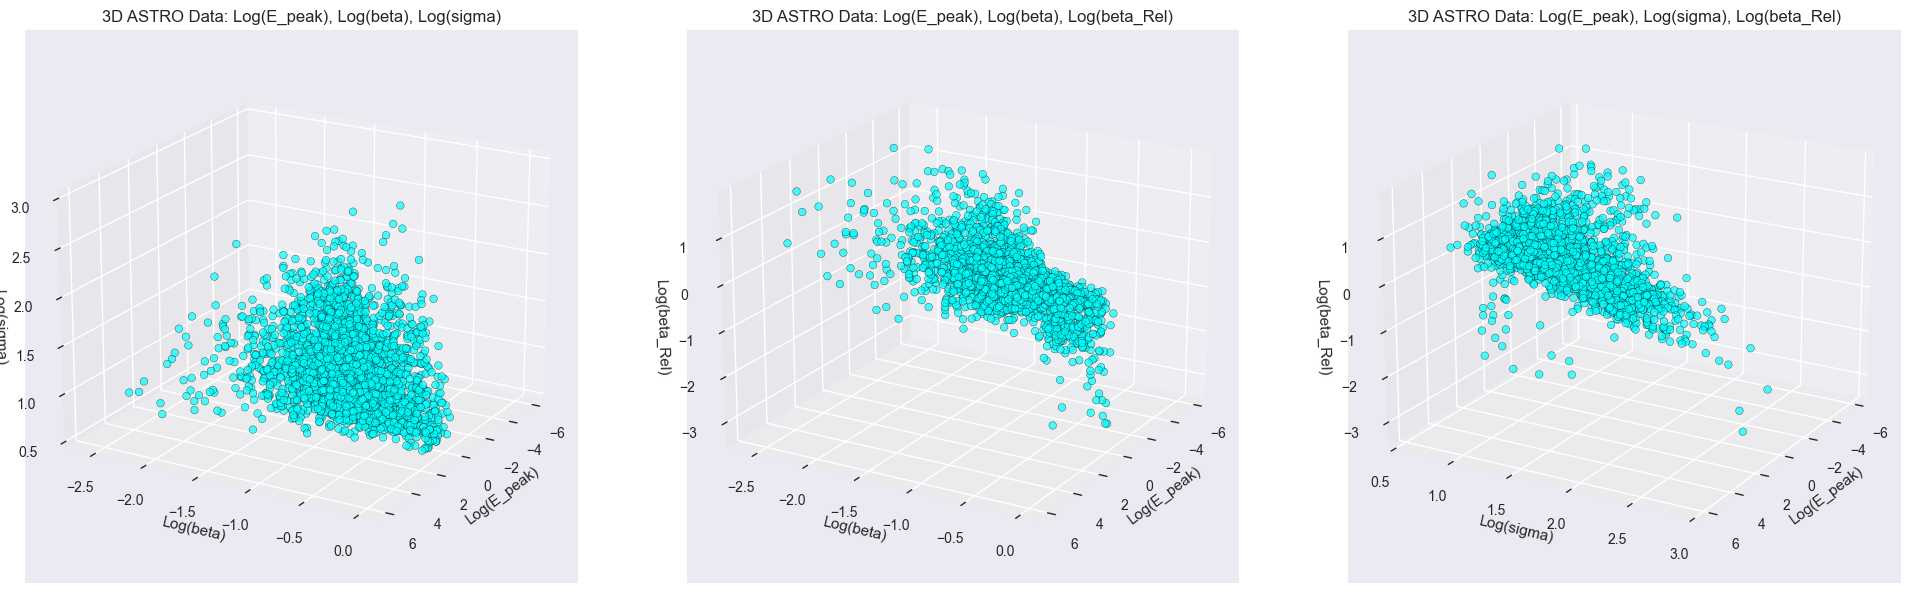

In [726]:
# Crear múltiples gráficos 3D con diferentes combinaciones
fig = plt.figure(figsize=(20, 6))

# Combinaciones 3D más representativas
combinations_3d = [
    ('Log(E_peak)', 'Log(beta)', 'Log(sigma)'),
    ('Log(E_peak)', 'Log(beta)', 'Log(beta_Rel)'),
    ('Log(E_peak)', 'Log(sigma)', 'Log(beta_Rel)'),
    ('Log(beta)', 'Log(sigma)', 'Log(beta_Rel)')
]

for idx, (feat1, feat2, feat3) in enumerate(combinations_3d[:3]):  # Solo 3 gráficos
    ax = fig.add_subplot(1, 3, idx+1, projection='3d')
    
    x = df_astro[feat1]
    y = df_astro[feat2] 
    z = df_astro[feat3]
    labels = df_astro['class']
    
    scatter = ax.scatter(x, y, z, c=labels, cmap='cool', edgecolor='k', alpha=0.7, s=30)
    
    ax.set_xlabel(feat1)
    ax.set_ylabel(feat2)
    ax.set_zlabel(feat3)
    ax.set_title(f'3D ASTRO Data: {feat1}, {feat2}, {feat3}')
    ax.view_init(elev=20, azim=30)

plt.tight_layout()
plt.show()

In [727]:

# Seleccionamos las features dinámicamente
X = df_astro[features].values
y = df_astro[target].values

print(f"Forma del dataset: {X.shape}")
print(f"Distribución de clases: {np.unique(y, return_counts=True)}")

# Como todos los datos son clase 0, stratify no es necesario y puede causar errores
# Simplificamos a:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

Forma del dataset: (2831, 4)
Distribución de clases: (array([0.]), array([2831]))
Train: 1698, Val: 566, Test: 567


In [728]:

"""
PARAMETROS DE OneClassSVM:

- kernel: rbf (solo cambiar si conocemos la fórmula para la forma de la distribución)
- gamma: 
    - coeficiente del kernel 
    - usado para hiperplanos no lineares
    - influye en la forma de la frontera de decisión + el desempeño predictivo
    - define la influencia de un único ejemplo de entrenamiento
    - cuanto más grande, más cerca tienen que estar los otros ejemplos para 'verse afectados'
    - (por defecto 'scale' (antes 'auto')) 
- nu: 
    - límite superior de la fracción de errores permitidos en entrenamiento 
    - límite inferior de la fracción de vectores de soporte en relación con nº total de datos de entrenamiento
        -   ejemplo: si se establece en 0,05 se tiene la garantía de encontrar como máximo el 5 % de los datos de entrenamiento mal clasificados 
            y al menos el 5 % de los datos de entrenamiento siendo vectores de soporte
    - ( (0,1] - 0.5 por defecto )
"""

# Parámetros optimizados para 4D
# γ más pequeño para evitar overfitting en alta dimensionalidad
selected_gamma = 0.02  # 0.02 - Menor que 0.1 usado en 2D
selected_nu = 0.002    # 0.001 - Mantenemos la misma expectativa de outliers

print(f"Parámetros: γ={selected_gamma}, ν={selected_nu}")

# Entrenar modelo final con todos los datos astro (train + val)
X_final_train = np.vstack([X_train, X_val])
y_final_train = np.concatenate([y_train, y_val])

# Scaler final - SOLO ajustar con datos de entrenamiento
scaler_final = StandardScaler()
X_final_train_scaled = scaler_final.fit_transform(X_final_train)

Parámetros: γ=0.02, ν=0.002


In [729]:
# Modelo final
final_model = OneClassSVM(kernel='rbf', gamma=selected_gamma, nu=selected_nu)
final_model.fit(X_final_train_scaled)

OneClassSVM(gamma=0.02, nu=0.002)

In [730]:
# Hacer predicciones con el modelo final entrenado sobre datos de prueba

# CRÍTICO: Solo transform (NO fit_transform) para datos de test
X_test_scaled = scaler_final.transform(X_test)

# Análisis de la distribución de scores
decision_scores_test = final_model.decision_function(X_test_scaled)

print(f"\nDecision scores estadísticas:")
print(f"  Media: {np.mean(decision_scores_test):.4f}")
print(f"  Std: {np.std(decision_scores_test):.4f}")
print(f"  Min: {np.min(decision_scores_test):.4f}")
print(f"  Max: {np.max(decision_scores_test):.4f}")


Decision scores estadísticas:
  Media: 0.3185
  Std: 0.0876
  Min: -0.1286
  Max: 0.4277


In [731]:

# Evaluar en test
test_preds = final_model.predict(X_test_scaled)
test_labels = np.where(test_preds == 1, 0, 1)

# Separar inliers y outliers
inliers_mask = test_preds == 1
outliers_mask = test_preds == -1

n_inliers = np.sum(test_preds == 1)
n_outliers = np.sum(test_preds == -1)
total_samples = len(test_preds)

print(f"\nEvaluación en el conjunto de test:")
print(f"Total de muestras: {total_samples}")
print(f"Inliers detectados: {n_inliers} ({n_inliers/total_samples*100:.2f}%)")
print(f"Outliers detectados: {n_outliers} ({n_outliers/total_samples*100:.2f}%)")


Evaluación en el conjunto de test:
Total de muestras: 567
Inliers detectados: 563 (99.29%)
Outliers detectados: 4 (0.71%)


In [732]:
# Metricas
print("Matriz de confusión:")
cm = confusion_matrix(y_test, test_labels)
print(cm)

print(f"\nReporte de clasificación:")
print(classification_report(y_test, test_labels, target_names=unique_labels(y_test, test_labels).astype(str)))

Matriz de confusión:
[[563   4]
 [  0   0]]

Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       567
         1.0       0.00      0.00      0.00         0

    accuracy                           0.99       567
   macro avg       0.50      0.50      0.50       567
weighted avg       1.00      0.99      1.00       567



In [733]:
# Análisis de outliers detectados
if n_outliers > 0:
    outlier_features = X_test[outliers_mask]
    print(f"\nCaracterísticas de los {n_outliers} outliers detectados:")
    for i, feature in enumerate(features):
        values = outlier_features[:, i]
        print(f"  {feature}: [{np.min(values):.3f}, {np.max(values):.3f}]")
        
    # Decision scores de los outliers
    outlier_scores = decision_scores_test[outliers_mask]
    print(f"\nDecision scores de outliers:")
    print(f"  Media: {np.mean(outlier_scores):.4f}")
    print(f"  Rango: [{np.min(outlier_scores):.4f}, {np.max(outlier_scores):.4f}]")


Características de los 4 outliers detectados:
  Log(E_peak): [0.104, 5.919]
  Log(beta): [-2.585, 0.000]
  Log(sigma): [0.615, 1.069]
  Log(beta_Rel): [-2.886, 1.508]

Decision scores de outliers:
  Media: -0.0781
  Rango: [-0.1286, -0.0419]


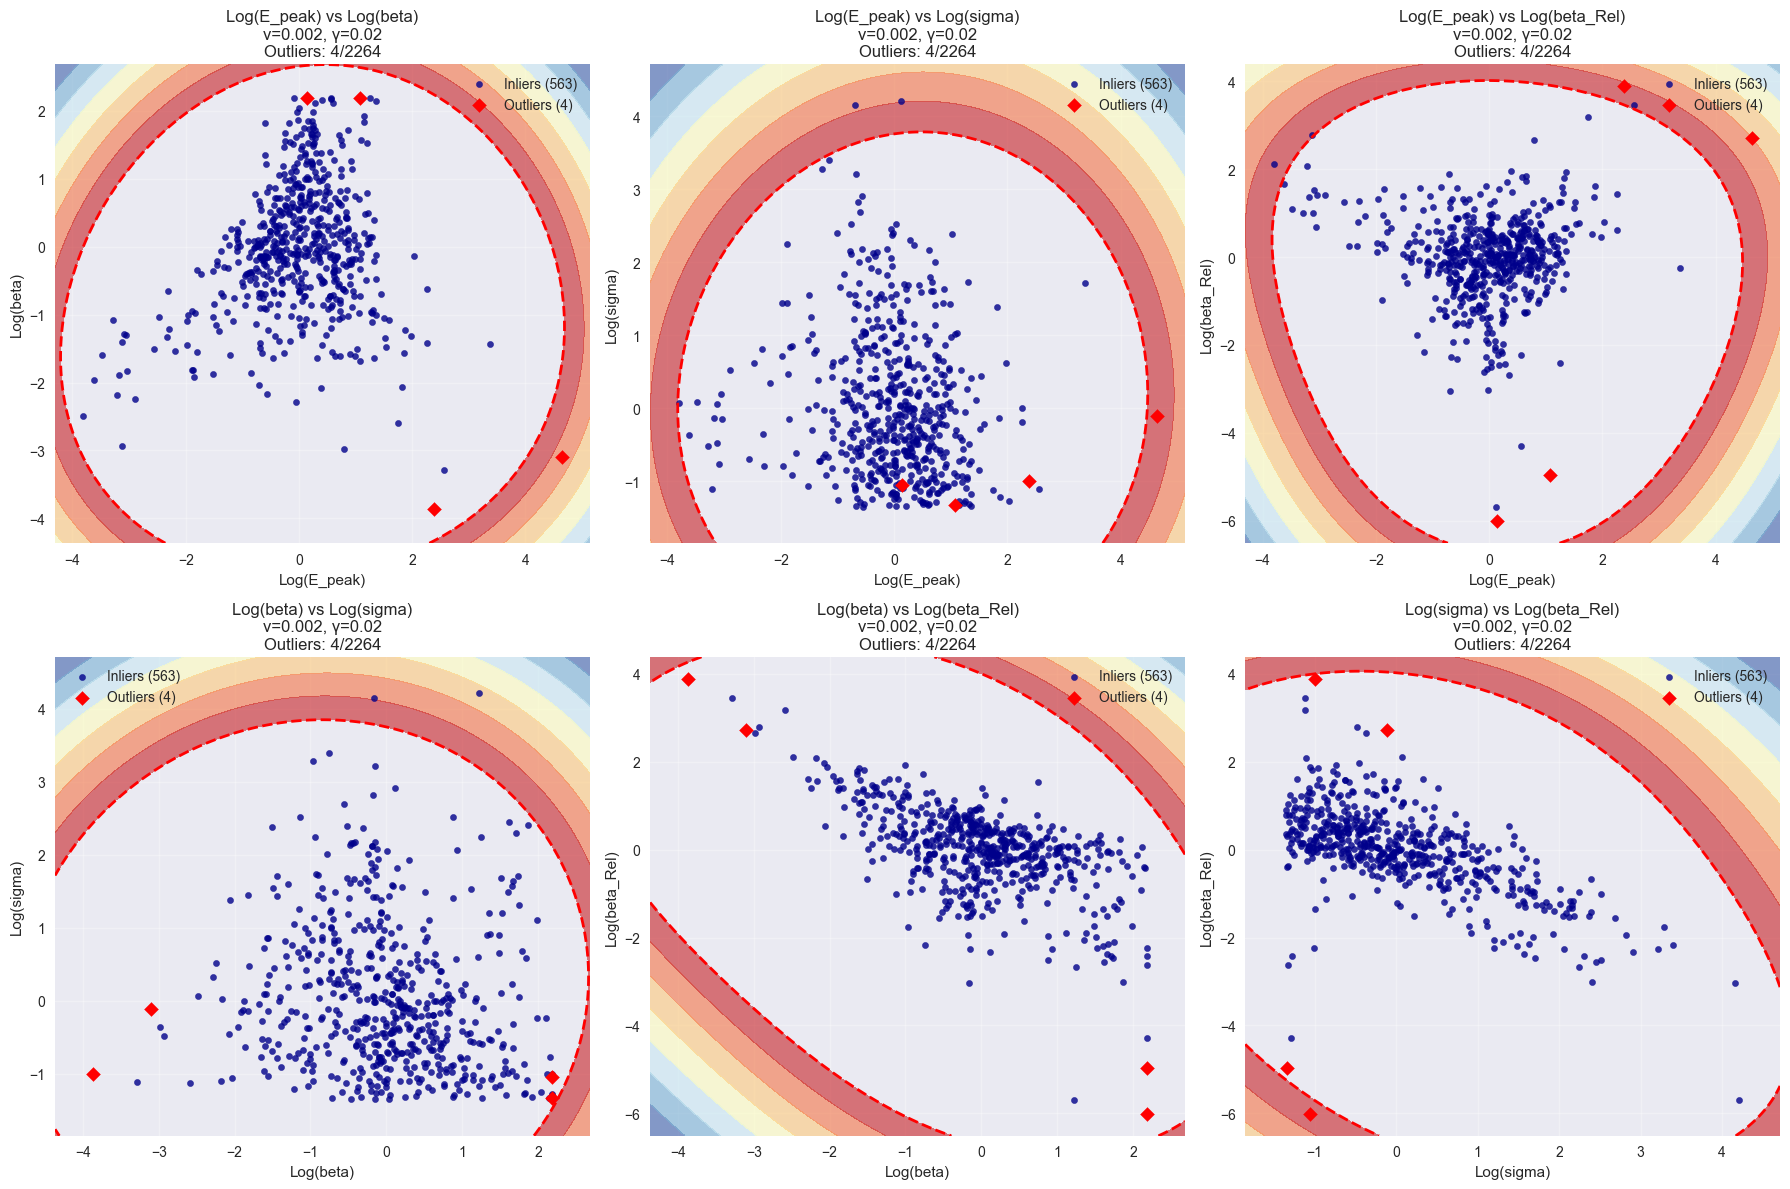

In [734]:
feature_names = ['Log(E_peak)', 'Log(beta)', 'Log(sigma)', 'Log(beta_Rel)']

feature_pairs = list(combinations(range(len(feature_names)), 2))
n_pairs = len(feature_pairs)

# Grid layout
cols = 3
rows = int(np.ceil(n_pairs / cols))
fig, axes = plt.subplots(rows, cols, figsize=(18, 6*rows))
if rows == 1:
    axes = axes.reshape(1, -1)

# Crear visualizaciones 2D
for i, (feature_idx1, feature_idx2) in enumerate(feature_pairs):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    
    # Crear grid para visualización (como en tu código)
    other_dims = [j for j in range(len(feature_names)) if j not in [feature_idx1, feature_idx2]]
    mean_values = [X_test_scaled[:, dim].mean() for dim in other_dims]
    
    x_min = X_test_scaled[:, feature_idx1].min() - 0.5
    x_max = X_test_scaled[:, feature_idx1].max() + 0.5
    y_min = X_test_scaled[:, feature_idx2].min() - 0.5
    y_max = X_test_scaled[:, feature_idx2].max() + 0.5
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 150), np.linspace(y_min, y_max, 150))
    
    # Grid 4D completo
    grid_points = []
    for k in range(xx.ravel().shape[0]):
        point_4d = [0] * len(feature_names)
        point_4d[feature_idx1] = xx.ravel()[k]
        point_4d[feature_idx2] = yy.ravel()[k]
        for j, other_dim in enumerate(other_dims):
            point_4d[other_dim] = mean_values[j]
        grid_points.append(point_4d)
    
    grid_4d = np.array(grid_points)
    Z = final_model.decision_function(grid_4d)
    Z = Z.reshape(xx.shape)
    
    # Visualización con el mismo estilo
    ax.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 8), cmap='RdYlBu_r', alpha=0.6)
    ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red', linestyles='--')
    
    # Plotear puntos con el mismo estilo
    ax.scatter(X_test_scaled[inliers_mask, feature_idx1], X_test_scaled[inliers_mask, feature_idx2], 
              c='darkblue', s=20, alpha=0.8, label=f'Inliers ({np.sum(inliers_mask)})')
    
    if np.any(outliers_mask):
        ax.scatter(X_test_scaled[outliers_mask, feature_idx1], X_test_scaled[outliers_mask, feature_idx2], 
                  c='red', s=50, alpha=1.0, marker='D', label=f'Outliers ({np.sum(outliers_mask)})')
    
    ax.set_xlabel(feature_names[feature_idx1])
    ax.set_ylabel(feature_names[feature_idx2])
    ax.set_title(f'{feature_names[feature_idx1]} vs {feature_names[feature_idx2]}\n'
                f'ν={selected_nu}, γ={selected_gamma}\n'
                f'Outliers: {np.sum(outliers_mask)}/{len(X_final_train)}')
    ax.grid(True, alpha=0.3)
    ax.legend()

# Ocultar subplots vacíos
for i in range(len(feature_pairs), rows * cols):
    row = i // cols
    col = i % cols
    axes[row, col].set_visible(False)

plt.tight_layout()
plt.show()

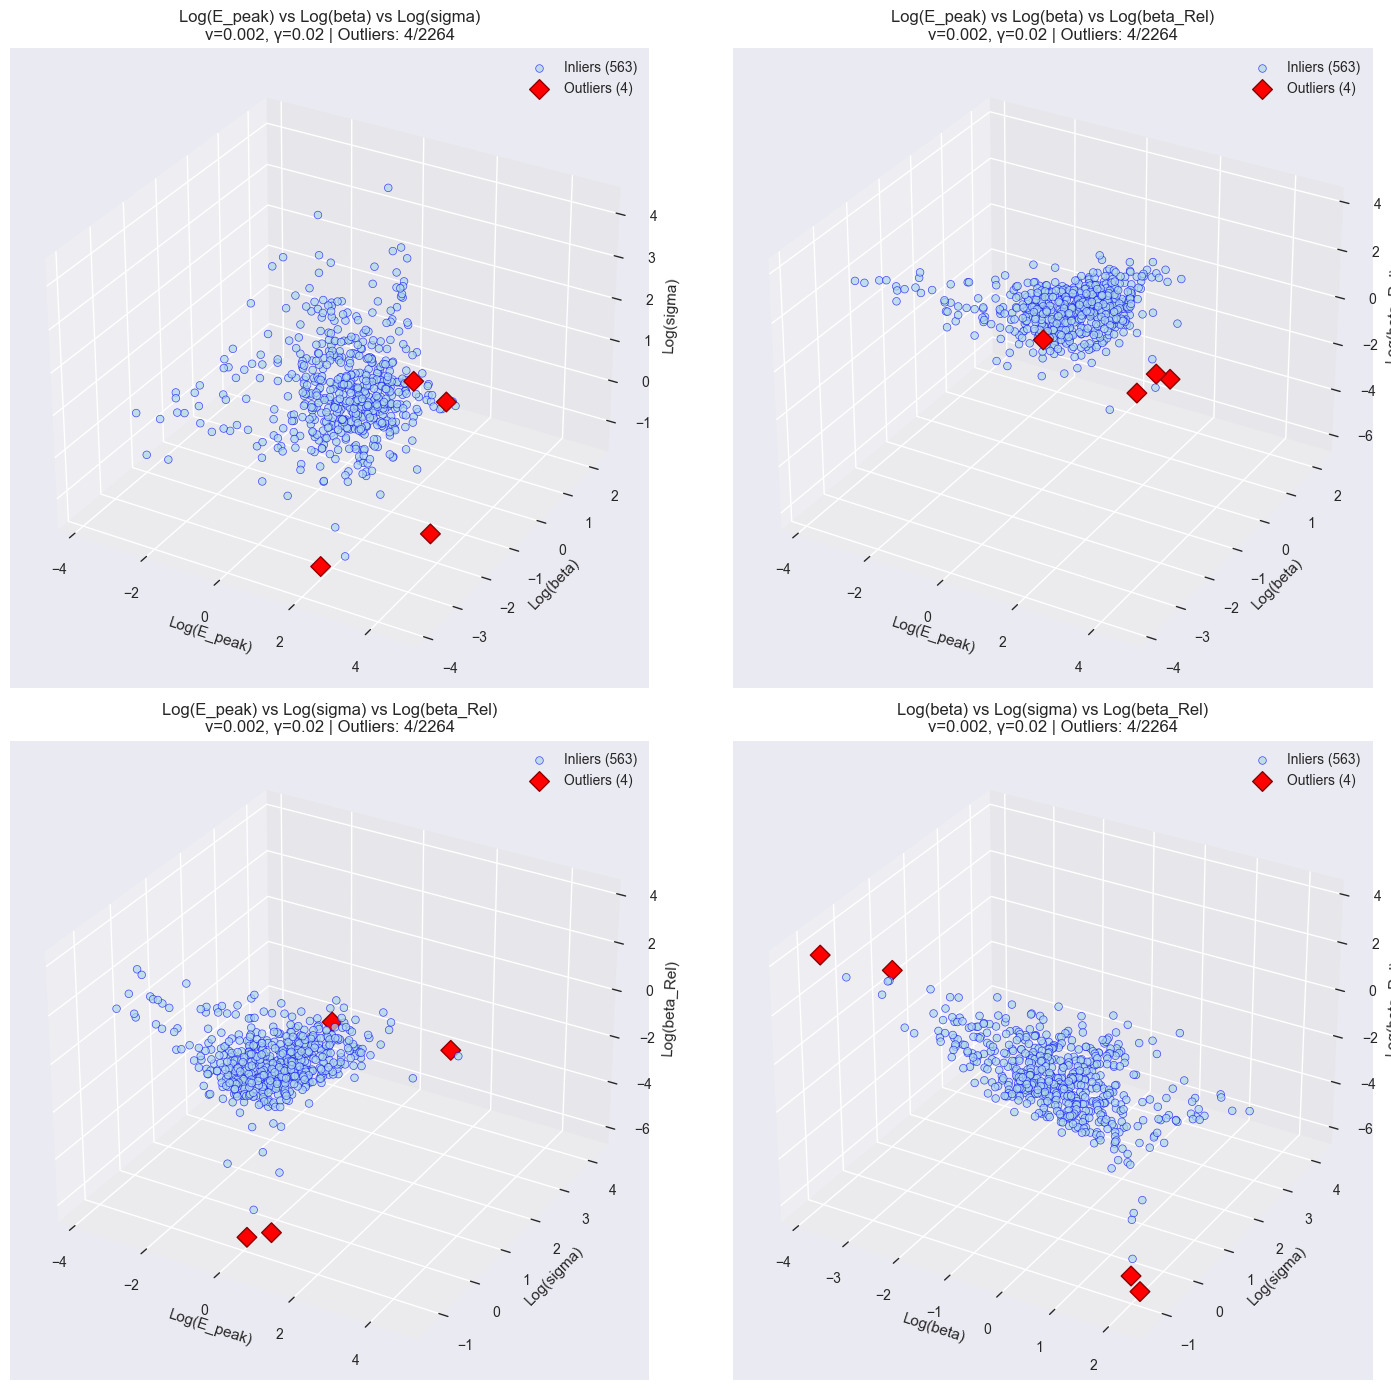

In [735]:
feature_triplets = list(combinations(range(len(feature_names)), 3))
n_triplets = len(feature_triplets)

# Grid layout 3D
cols_3d = 2
rows_3d = int(np.ceil(n_triplets / cols_3d))
fig = plt.figure(figsize=(15, 7*rows_3d))

# Crear visualizaciones 3D
for i, (f1_idx, f2_idx, f3_idx) in enumerate(feature_triplets):
    ax = fig.add_subplot(rows_3d, cols_3d, i+1, projection='3d')
    
    # Plotear inliers con borde para más definición
    ax.scatter(X_test_scaled[inliers_mask, f1_idx], 
               X_test_scaled[inliers_mask, f2_idx], 
               X_test_scaled[inliers_mask, f3_idx],
               c='lightblue', s=30, alpha=0.7, 
               edgecolor='blue', linewidth=0.5,
               label=f'Inliers ({np.sum(inliers_mask)})')
    
    if np.any(outliers_mask):
        ax.scatter(X_test_scaled[outliers_mask, f1_idx], 
                   X_test_scaled[outliers_mask, f2_idx], 
                   X_test_scaled[outliers_mask, f3_idx],
                   c='red', s=100, alpha=1.0, marker='D', 
                   edgecolor='darkred', linewidth=1,
                   label=f'Outliers ({np.sum(outliers_mask)})')
    
    ax.set_xlabel(feature_names[f1_idx])
    ax.set_ylabel(feature_names[f2_idx])
    ax.set_zlabel(feature_names[f3_idx])
    ax.set_title(f'{feature_names[f1_idx]} vs {feature_names[f2_idx]} vs {feature_names[f3_idx]}\n'
                f'ν={selected_nu}, γ={selected_gamma} | Outliers: {np.sum(outliers_mask)}/{len(X_final_train)}')
    ax.legend()

plt.tight_layout()
plt.show()


# Importar UNIDs

In [736]:
# Cargar datos UnIDs
unids_path = "../data/unids_log.txt"
df_unids = pd.read_csv(unids_path, sep='\s+')

print("Datos UnIDs cargados:")
print(f"Shape: {df_unids.shape}")
print("Primeras filas:")
display(df_unids.head())

# Verificar columnas disponibles
print(f"Columnas disponibles: {list(df_unids.columns)}")

Datos UnIDs cargados:
Shape: (1125, 5)
Primeras filas:


,Log(E_peak),Log(beta),Log(sigma_det),Log(beta_Rel),number
0,0.400175,-1.047208,0.869208,0.212452,0
1,0.169733,-0.380594,0.733598,-0.113037,1
2,0.203142,-0.168578,1.033058,-0.430366,2
3,-0.031074,-0.557363,0.881133,-0.201588,3
4,-0.351835,-0.493901,0.630916,-0.246028,4


Columnas disponibles: ['Log(E_peak)', 'Log(beta)', 'Log(sigma_det)', 'Log(beta_Rel)', 'number']


In [737]:
# Extraer características 4F
feature_cols = ["Log(E_peak)", "Log(beta)", "Log(sigma_det)", "Log(beta_Rel)"]
X_unids = df_unids[feature_cols].values

print(f"Características extraídas: {feature_cols}")
print(f"Shape características UnIDs: {X_unids.shape}")

Características extraídas: ['Log(E_peak)', 'Log(beta)', 'Log(sigma_det)', 'Log(beta_Rel)']
Shape características UnIDs: (1125, 4)


# Predecir sobre UNIDs

In [738]:
# Escalar características UnIDs
X_unids_scaled = scaler_final.transform(X_unids)

decision_scores = final_model.decision_function(X_unids_scaled)

unids_preds = final_model.predict(X_unids_scaled)

n_outliers = np.sum(unids_preds == -1)
outlier_percentage = n_outliers / len(unids_preds) * 100

print(f"RESULTADOS DE PREDICCIÓN:")
print(f"  - Total UnIDs analizadas: {len(unids_preds)}")
print(f"  - Outliers detectados: {n_outliers} ({outlier_percentage:.1f}%)")
print(f"  - Inliers detectados: {np.sum(unids_preds == 1)} ({100-outlier_percentage:.1f}%)")

# Calcular anomaly scores y rankings
# Invertir scores: valores más altos = más anómalos
anom_scores = -decision_scores

# Escalar a percentiles [0, 100]
anom_percent = MinMaxScaler(feature_range=(0, 100)).fit_transform(anom_scores.reshape(-1, 1)).flatten()

# Agregar resultados al DataFrame
df_unids_results = df_unids.copy()
df_unids_results["svm_score"] = decision_scores
df_unids_results["prediction"] = unids_preds
df_unids_results["Anomaly_Score"] = anom_scores
df_unids_results["Anomaly_Rank(%)"] = anom_percent

print("Scores calculados y agregados al DataFrame")

RESULTADOS DE PREDICCIÓN:
  - Total UnIDs analizadas: 1125
  - Outliers detectados: 5 (0.4%)
  - Inliers detectados: 1120 (99.6%)
Scores calculados y agregados al DataFrame


In [739]:
# Filtrar solo outliers y ordenar por anomaly rank
outliers_only = df_unids_results[df_unids_results["prediction"] == -1].copy()
outliers_sorted = outliers_only.sort_values(by="Anomaly_Rank(%)", ascending=False)

# Top 10 outliers más anómalos
top_10_outliers = outliers_sorted.head(10)

print(f"TOP 10 CANDIDATOS MÁS ANÓMALOS:")

# Mostrar información relevante
display_cols = ['Log(E_peak)', 'Log(beta)', 'Log(sigma_det)', 'Log(beta_Rel)', 
                'svm_score', 'Anomaly_Score', 'Anomaly_Rank(%)']

if 'number' in df_unids_results.columns:
    display_cols = ['number'] + display_cols

display(top_10_outliers[display_cols].round(4))

TOP 10 CANDIDATOS MÁS ANÓMALOS:


,number,Log(E_peak),Log(beta),Log(sigma_det),Log(beta_Rel),svm_score,Anomaly_Score,Anomaly_Rank(%)
307,307,1.5101,0.0000,0.6173,-3.0458,-0.1769,0.1769,100.0000
285,285,-0.7468,-1.2457,0.6598,1.8748,-0.0559,0.0559,79.8455
166,166,1.3292,0.0000,0.6372,-2.4202,-0.0337,0.0337,76.1549
923,923,-0.2177,-0.2478,0.6276,0.7369,-0.0328,0.0328,76.0013
1116,1116,0.7714,-2.6198,0.7473,1.5993,-0.0018,0.0018,70.8321


In [740]:
# Estadísticas de los outliers
print(f"\nESTADÍSTICAS DE OUTLIERS:")
print(f"  - Anomaly Score promedio: {outliers_only['Anomaly_Score'].mean():.4f} ± {outliers_only['Anomaly_Score'].std():.4f}")
print(f"  - Anomaly Rank promedio: {outliers_only['Anomaly_Rank(%)'].mean():.1f}% ± {outliers_only['Anomaly_Rank(%)'].std():.1f}%")
print(f"  - SVM Score promedio: {outliers_only['svm_score'].mean():.4f} ± {outliers_only['svm_score'].std():.4f}")


ESTADÍSTICAS DE OUTLIERS:
  - Anomaly Score promedio: 0.0602 ± 0.0680
  - Anomaly Rank promedio: 80.6% ± 11.3%
  - SVM Score promedio: -0.0602 ± 0.0680


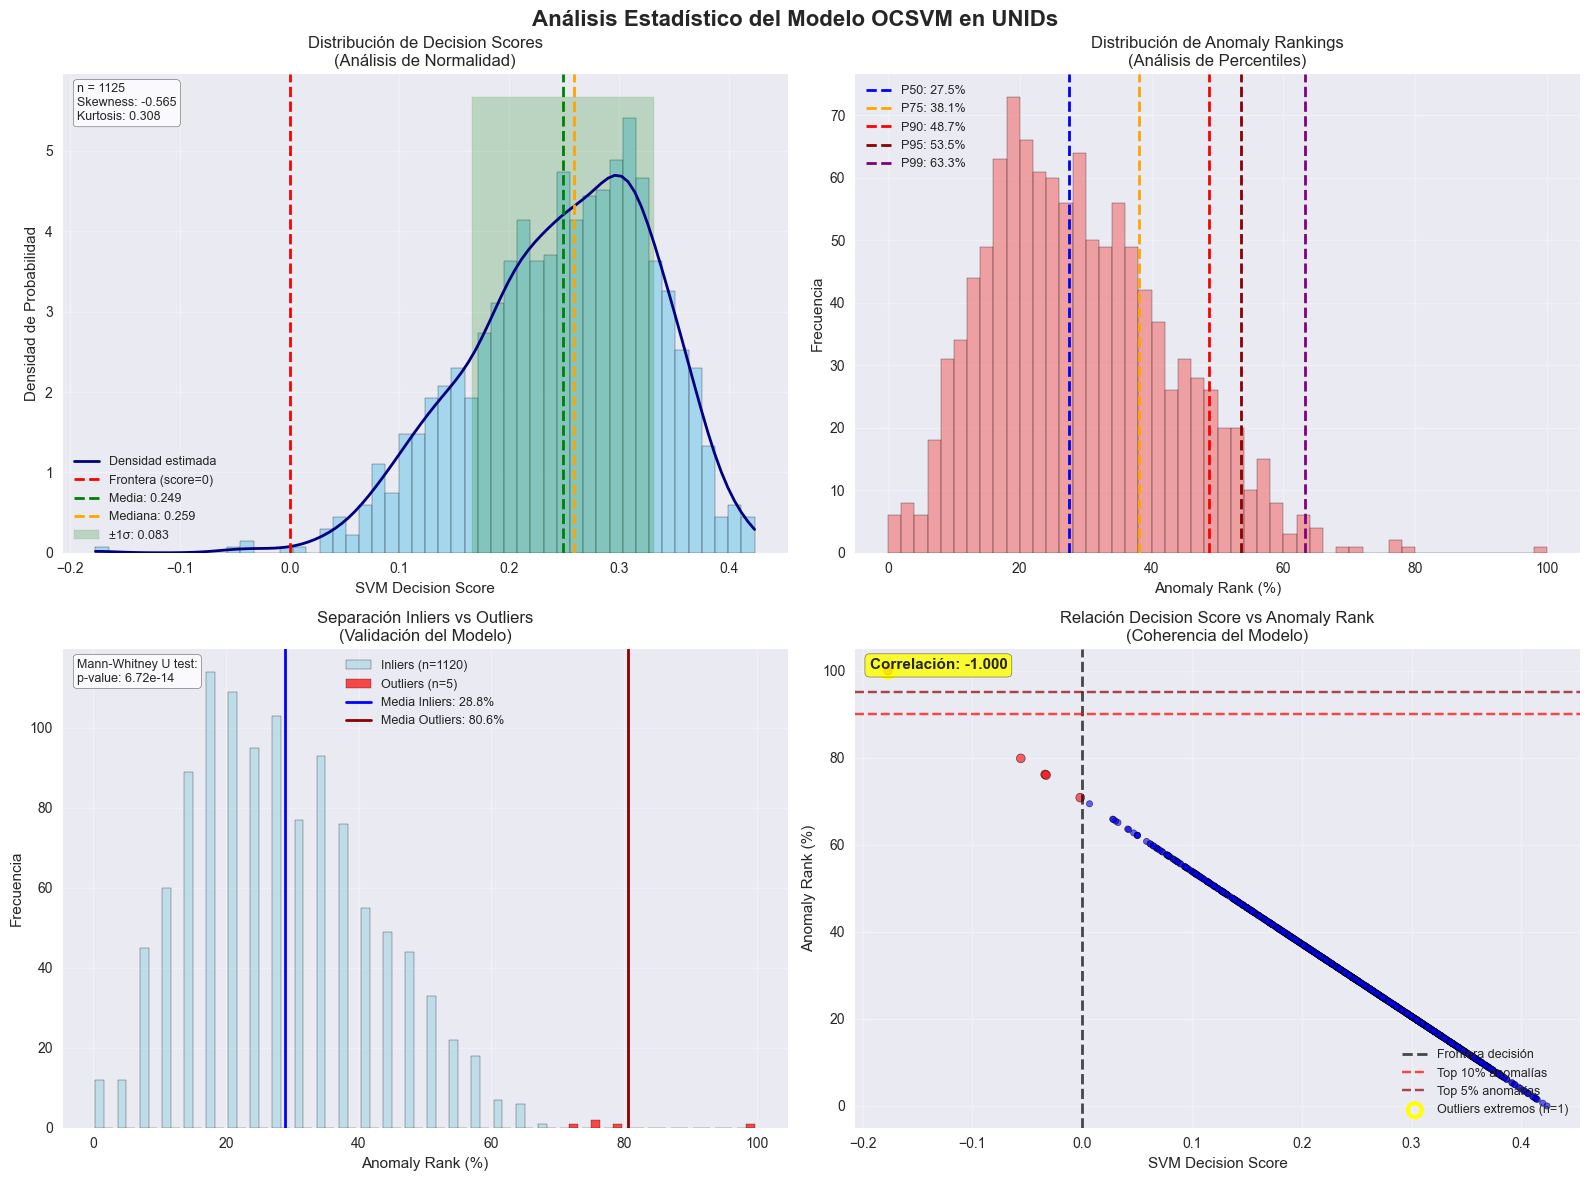

In [741]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análisis Estadístico del Modelo OCSVM en UNIDs', fontsize=16, fontweight='bold', y=0.98)

# 1. Distribución de Decision Scores CON ESTADÍSTICAS
ax1 = axes[0, 0]
n, bins, patches = ax1.hist(decision_scores, bins=50, alpha=0.7, color='skyblue', 
                           edgecolor='black', density=True)

# Añadir curva de densidad suavizada
x_smooth = np.linspace(decision_scores.min(), decision_scores.max(), 100)
density = stats.gaussian_kde(decision_scores)
ax1.plot(x_smooth, density(x_smooth), 'navy', linewidth=2, label='Densidad estimada')

# Líneas de referencia
ax1.axvline(0, color='red', linestyle='--', linewidth=2, label='Frontera (score=0)')
ax1.axvline(decision_scores.mean(), color='green', linestyle='--', linewidth=2,
           label=f'Media: {decision_scores.mean():.3f}')
ax1.axvline(np.median(decision_scores), color='orange', linestyle='--', linewidth=2,
           label=f'Mediana: {np.median(decision_scores):.3f}')

# Estadísticas adicionales
std_dev = decision_scores.std()
ax1.fill_betweenx([0, ax1.get_ylim()[1]], decision_scores.mean()-std_dev, 
                  decision_scores.mean()+std_dev, alpha=0.2, color='green', 
                  label=f'±1σ: {std_dev:.3f}')

ax1.set_xlabel('SVM Decision Score')
ax1.set_ylabel('Densidad de Probabilidad')
ax1.set_title('Distribución de Decision Scores\n(Análisis de Normalidad)')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Texto con estadísticas
stats_text = f'n = {len(decision_scores)}\nSkewness: {stats.skew(decision_scores):.3f}\nKurtosis: {stats.kurtosis(decision_scores):.3f}'
ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, fontsize=9, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Distribución de Anomaly Ranks CON PERCENTILES
ax2 = axes[0, 1]
ax2.hist(anom_percent, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')

# Percentiles importantes
percentiles = [50, 75, 90, 95, 99]
colors = ['blue', 'orange', 'red', 'darkred', 'purple']
for p, color in zip(percentiles, colors):
    value = np.percentile(anom_percent, p)
    ax2.axvline(value, color=color, linestyle='--', linewidth=2, 
               label=f'P{p}: {value:.1f}%')

ax2.set_xlabel('Anomaly Rank (%)')
ax2.set_ylabel('Frecuencia')
ax2.set_title('Distribución de Anomaly Rankings\n(Análisis de Percentiles)')
ax2.legend(fontsize=9, loc='upper left')
ax2.grid(True, alpha=0.3)

# 3. Comparación Inliers vs Outliers
ax3 = axes[1, 0]
outliers_scores = anom_percent[unids_preds == -1]
inliers_scores = anom_percent[unids_preds == 1]

# Histograma
bins = np.linspace(0, 100, 31)
ax3.hist([inliers_scores, outliers_scores], bins=bins, alpha=0.7,
         color=['lightblue', 'red'], label=[f'Inliers (n={len(inliers_scores)})', 
                                           f'Outliers (n={len(outliers_scores)})'],
         edgecolor='black')

# Añadir líneas de medias
ax3.axvline(inliers_scores.mean(), color='blue', linestyle='-', linewidth=2,
           label=f'Media Inliers: {inliers_scores.mean():.1f}%')
ax3.axvline(outliers_scores.mean(), color='darkred', linestyle='-', linewidth=2,
           label=f'Media Outliers: {outliers_scores.mean():.1f}%')

ax3.set_xlabel('Anomaly Rank (%)')
ax3.set_ylabel('Frecuencia')
ax3.set_title('Separación Inliers vs Outliers\n(Validación del Modelo)')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# Test estadístico
stat, p_value = stats.mannwhitneyu(outliers_scores, inliers_scores, alternative='greater')
test_text = f'Mann-Whitney U test:\np-value: {p_value:.2e}'
ax3.text(0.02, 0.98, test_text, transform=ax3.transAxes, fontsize=9,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. Scatter con regiones de interés
ax4 = axes[1, 1]
colors = ['red' if pred == -1 else 'blue' for pred in unids_preds]
sizes = [40 if pred == -1 else 20 for pred in unids_preds]

scatter = ax4.scatter(decision_scores, anom_percent, c=colors, alpha=0.6, s=sizes,
                     edgecolors='black', linewidth=0.5)

# Regiones de interés
ax4.axvline(0, color='black', linestyle='--', alpha=0.7, linewidth=2, label='Frontera decisión')
ax4.axhline(90, color='red', linestyle='--', alpha=0.7, label='Top 10% anomalías')
ax4.axhline(95, color='darkred', linestyle='--', alpha=0.7, label='Top 5% anomalías')

# Destacar zona de interés (outliers extremos)
extreme_mask = (unids_preds == -1) & (anom_percent > 95)
if np.any(extreme_mask):
    ax4.scatter(decision_scores[extreme_mask], anom_percent[extreme_mask], 
               s=100, facecolors='none', edgecolors='yellow', linewidth=3,
               label=f'Outliers extremos (n={np.sum(extreme_mask)})')

# Correlación
correlation = np.corrcoef(decision_scores, anom_percent)[0, 1]
ax4.text(0.02, 0.98, f'Correlación: {correlation:.3f}', transform=ax4.transAxes, 
         fontsize=11, verticalalignment='top', fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

ax4.set_xlabel('SVM Decision Score')
ax4.set_ylabel('Anomaly Rank (%)')
ax4.set_title('Relación Decision Score vs Anomaly Rank\n(Coherencia del Modelo)')
ax4.legend(fontsize=9, loc='lower right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

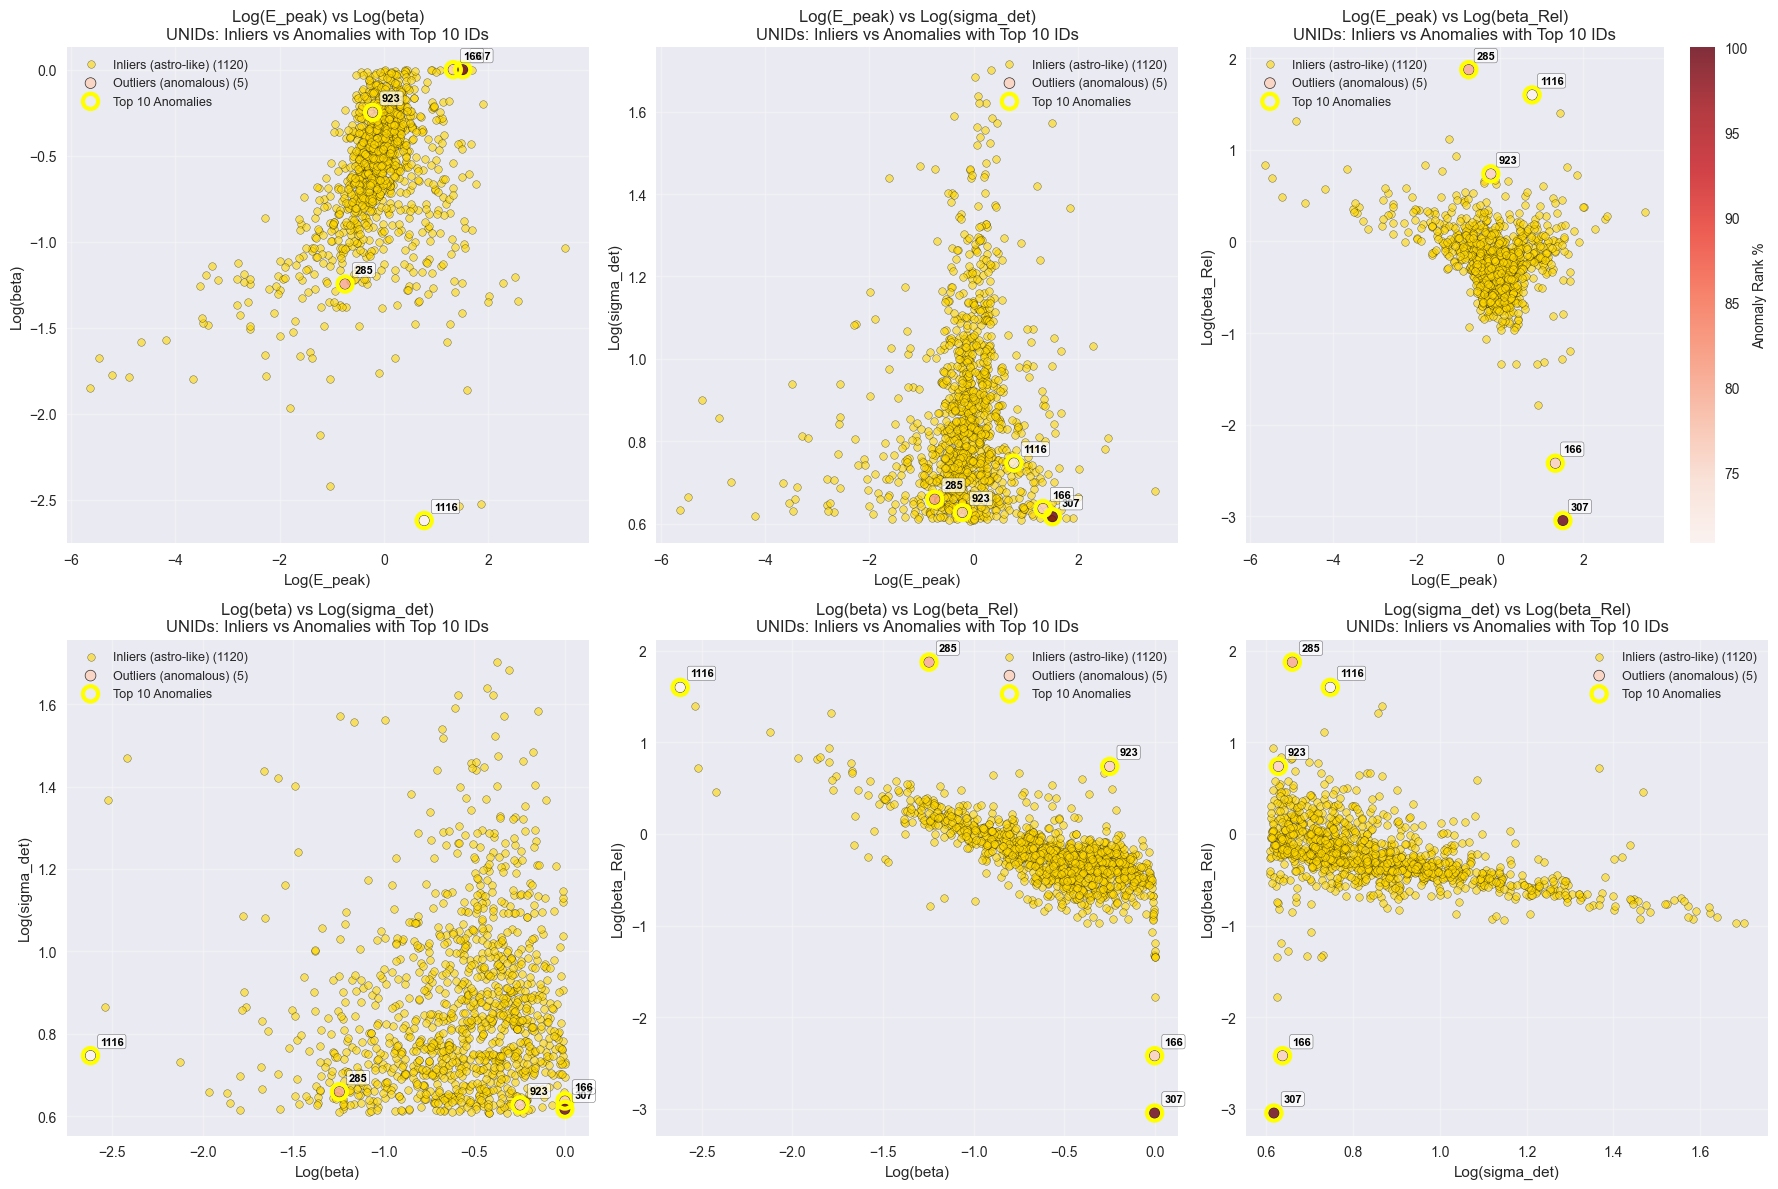

In [742]:
# GRID DE VISUALIZACIONES 2D DE UNIDs CON IDs DE ANOMALÍAS
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Todas las combinaciones 2D de las 4 características
feature_pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
feature_names = ['Log(E_peak)', 'Log(beta)', 'Log(sigma_det)', 'Log(beta_Rel)']

# Separar inliers y outliers
inliers_mask = unids_preds == 1
outliers_mask = unids_preds == -1
top_10_indices = top_10_outliers.index

for idx, (i, j) in enumerate(feature_pairs):
    ax = axes[idx//3, idx%3]
    
    # Plot inliers con el estilo gold
    ax.scatter(X_unids[inliers_mask, i], X_unids[inliers_mask, j],
               c='gold', alpha=0.6, s=30, edgecolors='black', linewidth=0.3,
               label=f'Inliers (astro-like) ({np.sum(inliers_mask)})')
    
    # Plot outliers con gradient de colores según anomaly rank
    if np.any(outliers_mask):
        scatter = ax.scatter(X_unids[outliers_mask, i], X_unids[outliers_mask, j],
                            c=anom_percent[outliers_mask], cmap='Reds', s=60,
                            alpha=0.8, edgecolors='black', linewidth=0.5, 
                            label=f'Outliers (anomalous) ({np.sum(outliers_mask)})')
        
        # Colorbar solo en el subplot superior derecho para no saturar
        if idx == 2:  # subplot (0,2) - esquina superior derecha
            cbar = plt.colorbar(scatter, ax=ax)
            cbar.set_label('Anomaly Rank %', fontsize=10)
    
    # Destacar top 10 con círculos amarillos
    if len(top_10_indices) > 0:
        ax.scatter(X_unids[top_10_indices, i], X_unids[top_10_indices, j],
                   s=120, facecolors='none', edgecolors='yellow', linewidth=3,
                   label=f'Top 10 Anomalies', marker='o')
        
        # Añadir etiquetas de ID para top 10
        for unid_idx in top_10_indices:
            x = X_unids[unid_idx, i]
            y = X_unids[unid_idx, j]
            
            # Obtener el número del UNID
            if 'number' in df_unids_results.columns:
                unid_id = int(df_unids_results.loc[unid_idx, 'number'])
            else:
                unid_id = unid_idx
            
            # Posicionar texto ligeramente desplazado para evitar solapamiento
            offset_x = (X_unids[:, i].max() - X_unids[:, i].min()) * 0.02
            offset_y = (X_unids[:, j].max() - X_unids[:, j].min()) * 0.02
            
            ax.text(x + offset_x, y + offset_y, str(unid_id), 
                   color='black', fontsize=8, fontweight='bold',
                   ha='left', va='bottom',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))
    
    # Configuración de ejes y título
    ax.set_xlabel(feature_names[i])
    ax.set_ylabel(feature_names[j])
    ax.set_title(f'{feature_names[i]} vs {feature_names[j]}\n'
                f'UNIDs: Inliers vs Anomalies with Top 10 IDs')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

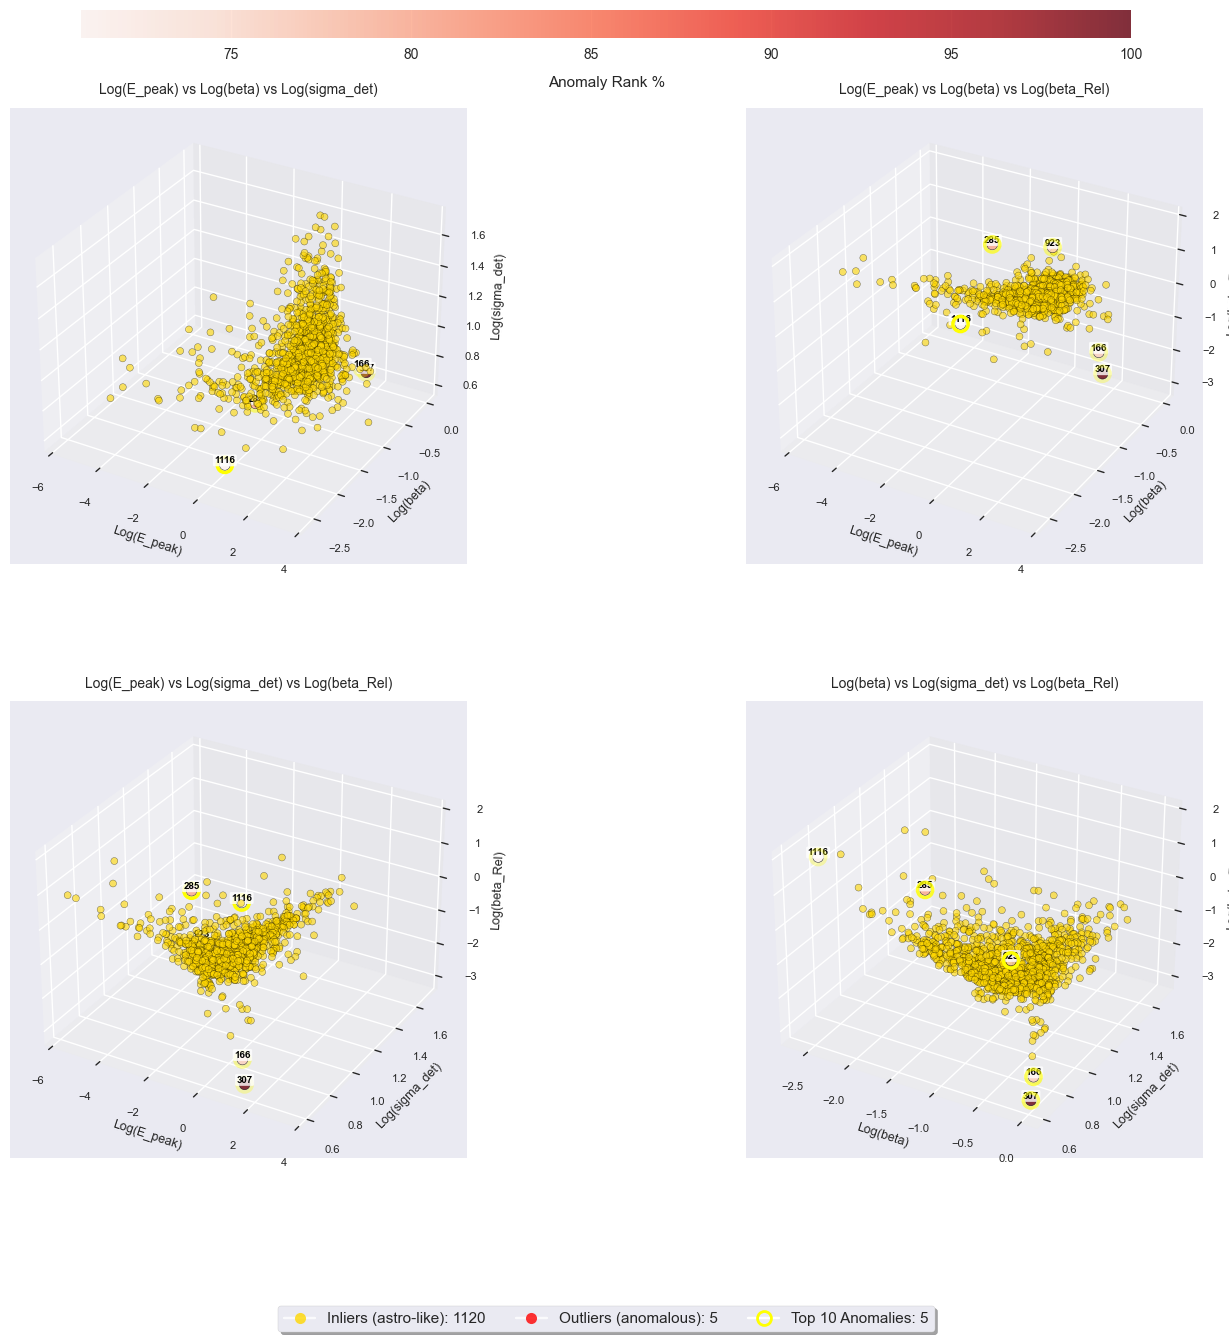

In [743]:
# GRID DE VISUALIZACIONES 3D DE UNIDs
feature_names = ['Log(E_peak)', 'Log(beta)', 'Log(sigma_det)', 'Log(beta_Rel)']
feature_triplets = list(combinations(range(len(feature_names)), 3))
n_triplets = len(feature_triplets)

# Grid layout 3D optimizado
cols_3d = 2
rows_3d = int(np.ceil(n_triplets / cols_3d))
fig = plt.figure(figsize=(15, 7*rows_3d))

# Separar inliers y outliers
inliers_mask = unids_preds == 1
outliers_mask = unids_preds == -1
top_10_indices = top_10_outliers.index

# Conteos para leyenda unificada
n_inliers = np.sum(inliers_mask)
n_outliers = np.sum(outliers_mask)
n_top10 = len(top_10_indices)

# Crear visualizaciones 3D
for i, (f1_idx, f2_idx, f3_idx) in enumerate(feature_triplets):
    ax = fig.add_subplot(rows_3d, cols_3d, i+1, projection='3d')
    
    # Plot inliers
    ax.scatter(X_unids[inliers_mask, f1_idx], 
               X_unids[inliers_mask, f2_idx], 
               X_unids[inliers_mask, f3_idx],
               c='gold', s=25, alpha=0.6, 
               edgecolor='black', linewidth=0.3)
    
    # Plot outliers con gradient de color según anomaly rank
    if np.any(outliers_mask):
        scatter = ax.scatter(X_unids[outliers_mask, f1_idx], 
                           X_unids[outliers_mask, f2_idx], 
                           X_unids[outliers_mask, f3_idx],
                           c=anom_percent[outliers_mask], cmap='Reds', s=60,
                           alpha=0.8, edgecolors='black', linewidth=0.4)
    
    # Destacar top 10 anomalías
    if len(top_10_indices) > 0:
        ax.scatter(X_unids[top_10_indices, f1_idx], 
                   X_unids[top_10_indices, f2_idx], 
                   X_unids[top_10_indices, f3_idx],
                   s=120, facecolors='none', edgecolors='yellow', 
                   linewidth=2.5)
        
        # Añadir etiquetas de ID con mejor posicionamiento
        for idx in top_10_indices:
            x = X_unids[idx, f1_idx]
            y = X_unids[idx, f2_idx] 
            z = X_unids[idx, f3_idx]
            
            # Obtener el número del UNID
            if 'number' in df_unids_results.columns:
                unid_id = int(df_unids_results.loc[idx, 'number'])
            else:
                unid_id = idx
            
            ax.text(x, y, z, str(unid_id), fontsize=7, color='black', 
                   fontweight='bold', ha='center', va='bottom',
                   bbox=dict(boxstyle='round,pad=0.15', facecolor='white', 
                            alpha=0.8, edgecolor='none'))
    
    # Configuración de ejes más compacta
    ax.set_xlabel(feature_names[f1_idx], fontsize=9)
    ax.set_ylabel(feature_names[f2_idx], fontsize=9)
    ax.set_zlabel(feature_names[f3_idx], fontsize=9)
    
    # Título más compacto
    title_short = f'{feature_names[f1_idx]} vs {feature_names[f2_idx]} vs {feature_names[f3_idx]}'
    ax.set_title(title_short, fontsize=10, pad=10)
    
    # Ajustar tamaño de ticks
    ax.tick_params(axis='both', which='major', labelsize=8)

# Colorbar unificado en la parte superior
if np.any(outliers_mask):
    # Crear un scatter dummy para el colorbar
    dummy_scatter = plt.scatter([], [], c=[], cmap='Reds', s=60, alpha=0.8)
    dummy_scatter.set_array(anom_percent[outliers_mask])
    
    # Colorbar en la parte superior
    cbar_ax = fig.add_axes([0.15, 0.95, 0.7, 0.02])  # [left, bottom, width, height]
    cbar = plt.colorbar(dummy_scatter, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Anomaly Rank %', fontsize=11, labelpad=10)

# Leyenda unificada en la parte inferior
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gold', 
               markeredgecolor='black', markersize=8, alpha=0.8,
               label=f'Inliers (astro-like): {n_inliers}'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markeredgecolor='black', markersize=8, alpha=0.8,
               label=f'Outliers (anomalous): {n_outliers}'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='none', 
               markeredgecolor='yellow', markersize=10, markeredgewidth=2,
               label=f'Top 10 Anomalies: {n_top10}')
]

fig.legend(handles=legend_elements, loc='lower center', ncol=3, 
          bbox_to_anchor=(0.5, 0.02), fontsize=11, frameon=True, 
          fancybox=True, shadow=True)

# Ajustar layout con más espacio para leyenda y colorbar
plt.subplots_adjust(top=0.90, bottom=0.15, left=0.05, right=0.95, 
                   hspace=0.3, wspace=0.2)
plt.show()


In [744]:
# ESTADÍSTICAS DETALLADAS DE UNIDs
print(f"\nESTADÍSTICAS UNIDs")
n_inliers = np.sum(inliers_mask)
n_outliers = np.sum(outliers_mask)
total_unids = len(unids_preds)

print(f"Total UNIDs analizados: {total_unids}")
print(f"Inliers (astro-like): {n_inliers} ({n_inliers/total_unids*100:.1f}%)")
print(f"Outliers (anomalous): {n_outliers} ({n_outliers/total_unids*100:.1f}%)")

print(f"\nTOP 10 ANOMALÍAS ETIQUETADAS:")
for i, idx in enumerate(top_10_indices):
    if 'number' in df_unids_results.columns:
        unid_id = int(df_unids_results.loc[idx, 'number'])
        rank = df_unids_results.loc[idx, 'Anomaly_Rank(%)']
        print(f"  {i+1:2d}. UNID {unid_id:3d} (Rank: {rank:5.1f}%)")
    else:
        rank = df_unids_results.loc[idx, 'Anomaly_Rank(%)']
        print(f"  {i+1:2d}. Índice {idx:3d} (Rank: {rank:5.1f}%)")


ESTADÍSTICAS UNIDs
Total UNIDs analizados: 1125
Inliers (astro-like): 1120 (99.6%)
Outliers (anomalous): 5 (0.4%)

TOP 10 ANOMALÍAS ETIQUETADAS:
   1. UNID 307 (Rank: 100.0%)
   2. UNID 285 (Rank:  79.8%)
   3. UNID 166 (Rank:  76.2%)
   4. UNID 923 (Rank:  76.0%)
   5. UNID 1116 (Rank:  70.8%)


# Compare UNIDs most anomalous vs ANN most DM-like

In [745]:
# Cargar resultados del consenso ANN 4F
ann_consensus = pd.read_csv('../data/results/ann/4F/consensus_analysis_ann_4f.csv')
print(f"Resultados ANN 4F cargados: {len(ann_consensus)} fuentes")

# Cargar resultados OCSVM 4F
ocsvm_results = df_unids_results.copy()  # O cargar desde archivo si está guardado
print(f"Resultados OCSVM 4F cargados: {len(ocsvm_results)} fuentes")

# Verificar mismo número de fuentes
if len(ann_consensus) != len(ocsvm_results):
    print(f" ADVERTENCIA: Diferentes números de fuentes - ANN: {len(ann_consensus)}, OCSVM: {len(ocsvm_results)}")
else:
    print(f"Mismo número de fuentes: {len(ann_consensus)}")

Resultados ANN 4F cargados: 1125 fuentes
Resultados OCSVM 4F cargados: 1125 fuentes
Mismo número de fuentes: 1125


In [746]:
print("Resultados (top unids) consenso ANN 4F:")
ann_consensus.head()

Resultados (top unids) consenso ANN 4F:


,Source_ID,E_peak,Beta,Sigma_det,Beta_Rel,log_E_peak,log_Beta,log_Sigma_det,log_Beta_Rel,Prob_Run1,Prob_Run2,Prob_Run3,Std_Run1,Std_Run2,Std_Run3,Mean_Prob_Consensus,Std_Prob_Consensus,Min_Prob_Consensus,Max_Prob_Consensus,Mean_Uncertainty_Consensus
0,371,13.85500,0.2306,5.0215,0.999133,1.141607,-0.637141,0.700833,-0.000377,0.774770,0.772964,0.806131,0.399808,0.416598,0.372890,0.784622,0.018650,0.772964,0.806131,0.396432
1,821,1.54370,0.6922,9.8576,0.311182,0.188563,-0.159768,0.993771,-0.506986,0.715743,0.712077,0.802501,0.331793,0.334242,0.398867,0.743440,0.051181,0.712077,0.802501,0.354967
2,596,1.27120,0.4036,19.3727,0.230922,0.104214,-0.394049,1.287190,-0.636535,0.649508,0.711889,0.653177,0.407760,0.384005,0.292166,0.671525,0.035004,0.649508,0.711889,0.361310
3,556,0.07633,0.0593,4.2719,1.487352,-1.117305,-1.226945,0.630621,0.172414,0.637254,0.697927,0.651670,0.248562,0.206301,0.193634,0.662284,0.031699,0.637254,0.697927,0.216166
4,106,13.89300,0.1439,11.8161,0.610841,1.142796,-0.841939,1.072474,-0.214072,0.592502,0.653579,0.627548,0.229078,0.263266,0.297331,0.624543,0.030649,0.592502,0.653579,0.263225


In [747]:
print('Resultados (todos) OCSVM 2F:')
ocsvm_results.head()

Resultados (todos) OCSVM 2F:


,Log(E_peak),Log(beta),Log(sigma_det),Log(beta_Rel),number,svm_score,prediction,Anomaly_Score,Anomaly_Rank(%)
0,0.400175,-1.047208,0.869208,0.212452,0,0.362443,1,-0.362443,10.159937
1,0.169733,-0.380594,0.733598,-0.113037,1,0.186084,1,-0.186084,39.539050
2,0.203142,-0.168578,1.033058,-0.430366,2,0.187756,1,-0.187756,39.260415
3,-0.031074,-0.557363,0.881133,-0.201588,3,0.278735,1,-0.278735,24.104700
4,-0.351835,-0.493901,0.630916,-0.246028,4,0.202496,1,-0.202496,36.805050


In [748]:
# Verificar alineamiento de IDs
ann_ids = ann_consensus['Source_ID'].values
ocsvm_ids = ocsvm_results['number'].values if 'number' in ocsvm_results.columns else ocsvm_results.index.values

ids_aligned = np.array_equal(ann_ids, ocsvm_ids)

if ids_aligned:
    print("Los IDs están alineados correctamente")
    ann_final = ann_consensus.copy()
    ocsvm_final = ocsvm_results.copy()
else:
    print("Los IDs NO están alineados - procediendo a alinear...")
    print(f"   Primeros 5 IDs ANN: {ann_ids[:5]}")
    print(f"   Primeros 5 IDs OCSVM: {ocsvm_ids[:5]}")
    
    # Alinear por ID común
    if 'number' in ocsvm_results.columns:
        ann_final = ann_consensus.sort_values('Source_ID').reset_index(drop=True)
        ocsvm_final = ocsvm_results.sort_values('number').reset_index(drop=True)
        
        # Verificar alineamiento después de ordenar
        if np.array_equal(ann_final['Source_ID'].values, ocsvm_final['number'].values):
            print("IDs alineados correctamente después de ordenar")
        else:
            print("ERROR: No se pudieron alinear los IDs - revisar datos")
            # Mostrar diferencias
            ann_set = set(ann_final['Source_ID'].values)
            ocsvm_set = set(ocsvm_final['number'].values)
            print(f"   IDs solo en ANN: {ann_set - ocsvm_set}")
            print(f"   IDs solo en OCSVM: {ocsvm_set - ann_set}")
    else:
        print("ERROR: Columna 'number' no encontrada en OCSVM results")
        ann_final = ann_consensus.copy()
        ocsvm_final = ocsvm_results.copy()

Los IDs NO están alineados - procediendo a alinear...
   Primeros 5 IDs ANN: [371 821 596 556 106]
   Primeros 5 IDs OCSVM: [0 1 2 3 4]
IDs alineados correctamente después de ordenar


In [749]:
# CREAR DATAFRAME COMBINADO

# Verificar columnas necesarias existen
required_ann_cols = ['Source_ID', 'E_peak', 'Beta', 'log_E_peak', 'log_Beta', 'log_Sigma_det', 'log_Beta_Rel', 'Mean_Prob_Consensus', 'Std_Prob_Consensus']
required_ocsvm_cols = ['prediction', 'Anomaly_Score', 'Anomaly_Rank(%)']

missing_ann = [col for col in required_ann_cols if col not in ann_final.columns]
missing_ocsvm = [col for col in required_ocsvm_cols if col not in ocsvm_final.columns]

if missing_ann:
    print(f"Columnas faltantes en ANN: {missing_ann}")
if missing_ocsvm:
    print(f"Columnas faltantes en OCSVM: {missing_ocsvm}")

if not missing_ann and not missing_ocsvm:
    comparison_df = pd.DataFrame({
        # IDs y características originales
        'Source_ID': ann_final['Source_ID'].values,
        'E_peak': ann_final['E_peak'].values,
        'Beta': ann_final['Beta'].values,
        'Log_E_peak': ann_final['log_E_peak'].values,
        'Log_Beta': ann_final['log_Beta'].values,
        'Log_Sigma_det': ann_final['log_Sigma_det'].values,
        'log_Beta_Rel': ann_final['log_Beta_Rel'].values,
        
        # Resultados ANN 2F
        'ANN_Prob_Mean': ann_final['Mean_Prob_Consensus'].values,
        'ANN_Prob_Std': ann_final['Std_Prob_Consensus'].values,
        
        # Resultados OCSVM 2F
        'OCSVM_Prediction': ocsvm_final['prediction'].values,  # 1=inlier, -1=outlier
        'OCSVM_Anomaly_Score': ocsvm_final['Anomaly_Score'].values,
        'OCSVM_Anomaly_Rank': ocsvm_final['Anomaly_Rank(%)'].values,
    })
    
else:
    print("No se pudo crear el DataFrame combinado debido a columnas faltantes")
    comparison_df = None

In [750]:
# DIAGNÓSTICO DIRECTO ANN 4F vs OCSVM 4F
print("DIAGNÓSTICO ANN 4F vs OCSVM 4F")

print("-" * 60)
print(f"ANN 4F - Media: {comparison_df['ANN_Prob_Mean'].mean():.4f} | "
      f"Mediana: {comparison_df['ANN_Prob_Mean'].median():.4f} | "
      f"Rango: [{comparison_df['ANN_Prob_Mean'].min():.4f}-{comparison_df['ANN_Prob_Mean'].max():.4f}]")

print(f"OCSVM 4F - Media: {comparison_df['OCSVM_Anomaly_Rank'].mean():.1f}% | "
      f"Mediana: {comparison_df['OCSVM_Anomaly_Rank'].median():.1f}% | "
      f"Rango: [{comparison_df['OCSVM_Anomaly_Rank'].min():.1f}%-{comparison_df['OCSVM_Anomaly_Rank'].max():.1f}%]")

# IDENTIFICACIÓN DE CANDIDATOS
print("-" * 60)
print(f"\nIDENTIFICACIÓN DE CANDIDATOS:")
ann_threshold = np.percentile(comparison_df['ANN_Prob_Mean'], 95)
ocsvm_threshold = np.percentile(comparison_df['OCSVM_Anomaly_Rank'], 95)

top_ann = comparison_df[comparison_df['ANN_Prob_Mean'] >= ann_threshold].sort_values('ANN_Prob_Mean', ascending=False)
ocsvm_outliers = comparison_df[comparison_df['OCSVM_Prediction'] == -1].sort_values('OCSVM_Anomaly_Rank', ascending=False)
top_ocsvm = comparison_df[comparison_df['OCSVM_Anomaly_Rank'] >= ocsvm_threshold].sort_values('OCSVM_Anomaly_Rank', ascending=False)

print(f"Top ANN (P95={ann_threshold:.4f}): {len(top_ann)} fuentes")
print(f"OCSVM Outliers: {len(ocsvm_outliers)} fuentes")
print(f"Top OCSVM (P95={ocsvm_threshold:.1f}%): {len(top_ocsvm)} fuentes")

# SOLAPAMIENTOS
print(f"\nSOLAPAMIENTOS:")
overlap_restrictivo = set(top_ann['Source_ID']) & set(ocsvm_outliers['Source_ID'])
overlap_amplio = set(top_ann['Source_ID']) & set(top_ocsvm['Source_ID'])

print(f"Top ANN ∩ OCSVM Outliers: {len(overlap_restrictivo)} fuentes")
if overlap_restrictivo:
    print(f"  IDs: {sorted(list(overlap_restrictivo))}")

print(f"Top ANN ∩ Top OCSVM: {len(overlap_amplio)} fuentes")
if overlap_amplio:
    print(f"  IDs: {sorted(list(overlap_amplio))}")

# TOP 10 COMPARACIÓN DIRECTA
print(f"\nTOP 10 ANN vs OCSVM:")
print("-" * 60)
for i, (_, row) in enumerate(top_ann.head(10).iterrows()):
    status = "Outlier" if row['OCSVM_Prediction'] == -1 else "Normal"
    print(f"{i+1:2d}. ID {int(row['Source_ID']):4d}: ANN={row['ANN_Prob_Mean']:.4f} | OCSVM={row['OCSVM_Anomaly_Rank']:5.1f}% {status}")

print(f"\nOUTLIERS OCSVM vs ANN:")
print("-" * 60)
if len(ocsvm_outliers) > 0:
    for i, (_, row) in enumerate(ocsvm_outliers.iterrows()):
        print(f"{i+1:2d}. ID {int(row['Source_ID']):4d}: OCSVM={row['OCSVM_Anomaly_Rank']:5.1f}% | ANN={row['ANN_Prob_Mean']:.4f}")
else:
    print("No hay outliers detectados por OCSVM")

# ANÁLISIS DE CONCORDANCIA
print(f"\nANÁLISIS DE CONCORDANCIA:")
# Correlación entre métricas
correlation = np.corrcoef(comparison_df['ANN_Prob_Mean'], comparison_df['OCSVM_Anomaly_Rank'])[0, 1]
print(f"Correlación ANN-OCSVM: {correlation:.4f}")

# Concordancia en clasificación binaria
ann_high = comparison_df['ANN_Prob_Mean'] >= ann_threshold
ocsvm_high = comparison_df['OCSVM_Anomaly_Rank'] >= ocsvm_threshold

concordancia = np.mean(ann_high == ocsvm_high) * 100
print(f"Concordancia en top 5%: {concordancia:.1f}%")

# Casos discrepantes
discrepantes_ann_high_ocsvm_low = comparison_df[(comparison_df['ANN_Prob_Mean'] >= ann_threshold) & 
                                               (comparison_df['OCSVM_Anomaly_Rank'] < 50)]
discrepantes_ocsvm_high_ann_low = comparison_df[(comparison_df['OCSVM_Anomaly_Rank'] >= ocsvm_threshold) & 
                                               (comparison_df['ANN_Prob_Mean'] < 0.5)]

print(f"Discrepantes (ANN alta, OCSVM baja): {len(discrepantes_ann_high_ocsvm_low)}")
print(f"Discrepantes (OCSVM alta, ANN baja): {len(discrepantes_ocsvm_high_ann_low)}")

print("-" * 60)
# RESUMEN EJECUTIVO
print(f"\nRESUMEN EJECUTIVO:")
if len(overlap_restrictivo) > 0:
    print(f"Consenso encontrado: {len(overlap_restrictivo)} fuentes identificadas por ambos métodos")
else:
    print("Sin consenso directo entre métodos")

if abs(correlation) > 0.5:
    print(f"Correlación moderada-alta: {correlation:.3f}")
else:
    print(f"Correlación baja: {correlation:.3f}")

if concordancia > 70:
    print(f"Buena concordancia en top candidatos: {concordancia:.1f}%")
else:
    print(f"Baja concordancia en top candidatos: {concordancia:.1f}%")

DIAGNÓSTICO ANN 4F vs OCSVM 4F
------------------------------------------------------------
ANN 4F - Media: 0.2271 | Mediana: 0.2129 | Rango: [0.0000-0.7846]
OCSVM 4F - Media: 29.1% | Mediana: 27.5% | Rango: [0.0%-100.0%]
------------------------------------------------------------

IDENTIFICACIÓN DE CANDIDATOS:
Top ANN (P95=0.4426): 57 fuentes
OCSVM Outliers: 5 fuentes
Top OCSVM (P95=53.5%): 57 fuentes

SOLAPAMIENTOS:
Top ANN ∩ OCSVM Outliers: 0 fuentes
Top ANN ∩ Top OCSVM: 1 fuentes
  IDs: [770]

TOP 10 ANN vs OCSVM:
------------------------------------------------------------
 1. ID  371: ANN=0.7846 | OCSVM= 29.8% Normal
 2. ID  821: ANN=0.7434 | OCSVM= 39.3% Normal
 3. ID  596: ANN=0.6715 | OCSVM= 20.6% Normal
 4. ID  556: ANN=0.6623 | OCSVM= 16.0% Normal
 5. ID  106: ANN=0.6245 | OCSVM=  9.1% Normal
 6. ID  172: ANN=0.6165 | OCSVM= 33.6% Normal
 7. ID   29: ANN=0.5969 | OCSVM= 52.1% Normal
 8. ID  560: ANN=0.5854 | OCSVM= 20.2% Normal
 9. ID  781: ANN=0.5789 | OCSVM= 40.0% Normal
